continue from 1:52:58 of session 3

session 1 -> intro to aws sagemaker : https://www.youtube.com/watch?v=CnNo90dL6Lo&embeds_referring_euri=https%3A%2F%2Flearnwith.campusx.in%2F&
embeds_referring_origin=https%3A%2F%2Flearnwith.campusx.in&source_ve_path=MzY4NDIsMjM4NTE

session 2 -> github & data cleaning: https://www.youtube.com/watch?v=5L8TaXXGFsY

session 3 -> eda : https://www.youtube.com/watch?v=odZCToOTvSQ&t=1s

eda contd:  https://www.youtube.com/watch?v=aLYt0ShVANE&t=1s

feature engineering: https://www.youtube.com/watch?v=5Yg58Rlu9po

model training & deployment: https://www.youtube.com/watch?v=9sm7qHInUoA

### 1. Import Libraries

In [3]:
import eda_helper_functions

In [4]:
import os
import pandas as pd  
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [5]:
from sklearn.ensemble import IsolationForest

### 2. Read the training data

In [6]:
file_path = r"C:\Users\Abhinay\Desktop\flight-prediction-sageMaker\data\train.csv"
train = pd.read_csv(file_path)

In [7]:
train.shape

(640, 10)

In [8]:
train.head()

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Air India,2019-04-09,Delhi,Cochin,05:55:00,19:15:00,2240,2,No info,7711
1,Air India,2019-06-03,Delhi,Cochin,07:10:00,07:40:00,1470,2,No info,12698
2,Air India,2019-05-15,Kolkata,Banglore,16:45:00,21:05:00,1700,1,No info,7452
3,Vistara,2019-06-15,Chennai,Kolkata,07:05:00,09:20:00,135,0,No info,3687
4,Jet Airways,2019-04-09,Delhi,Cochin,23:05:00,19:00:00,1195,2,No info,9483


In [9]:
train.dtypes

airline            object
date_of_journey    object
source             object
destination        object
dep_time           object
arrival_time       object
duration            int64
total_stops         int64
additional_info    object
price               int64
dtype: object

now change the dtypes of 'date_of_journey', 'dep_time', 'arrival_time' 

In [10]:
train.date_of_journey

0      2019-04-09
1      2019-06-03
2      2019-05-15
3      2019-06-15
4      2019-04-09
          ...    
635    2019-03-06
636    2019-04-21
637    2019-06-09
638    2019-05-18
639    2019-03-24
Name: date_of_journey, Length: 640, dtype: object

In [11]:
# Keep only those that do NOT match YYYY-MM-DD
train[~train['date_of_journey'].str.match(r'^\d{4}-\d{2}-\d{2}$')]



,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price


In [12]:
train.dep_time

0      05:55:00
1      07:10:00
2      16:45:00
3      07:05:00
4      23:05:00
         ...   
635    11:30:00
636    02:00:00
637    22:15:00
638    14:20:00
639    13:55:00
Name: dep_time, Length: 640, dtype: object

In [13]:
# This will return True for rows where format is exactly HH:MM:SS
valid_time_format = train['arrival_time'].astype(str).str.match(r'^\d{2}:\d{2}:\d{2}$')

# Show rows with invalid time format
invalid_times = train[~valid_time_format]

print(f"Invalid arrival_time entries:\n{invalid_times[['arrival_time']]}")


Invalid arrival_time entries:
Empty DataFrame
Columns: [arrival_time]
Index: []


In [15]:
# train = train.assign(**{
# 	col: pd.to_datetime(train.loc[:, col])
# 	for col in ["date_of_journey", "dep_time", "arrival_time"]
# })

train = train.assign(
    date_of_journey=pd.to_datetime(train["date_of_journey"]),
    dep_time=pd.to_datetime(train["dep_time"], format="%H:%M:%S", errors="coerce").dt.time,
    arrival_time=pd.to_datetime(train["arrival_time"], format="%H:%M:%S", errors="coerce").dt.time
)


In [16]:
train.dtypes

airline                    object
date_of_journey    datetime64[ns]
source                     object
destination                object
dep_time                   object
arrival_time               object
duration                    int64
total_stops                 int64
additional_info            object
price                       int64
dtype: object

In [17]:
train.head(n=5)

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Air India,2019-04-09,Delhi,Cochin,05:55:00,19:15:00,2240,2,No info,7711
1,Air India,2019-06-03,Delhi,Cochin,07:10:00,07:40:00,1470,2,No info,12698
2,Air India,2019-05-15,Kolkata,Banglore,16:45:00,21:05:00,1700,1,No info,7452
3,Vistara,2019-06-15,Chennai,Kolkata,07:05:00,09:20:00,135,0,No info,3687
4,Jet Airways,2019-04-09,Delhi,Cochin,23:05:00,19:00:00,1195,2,No info,9483


In [28]:
train['dep_time'].apply(type).unique()


array([<class 'datetime.time'>], dtype=object)

### 3. High-level Summary of Data

In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   airline          640 non-null    object        
 1   date_of_journey  640 non-null    datetime64[ns]
 2   source           640 non-null    object        
 3   destination      640 non-null    object        
 4   dep_time         640 non-null    object        
 5   arrival_time     640 non-null    object        
 6   duration         640 non-null    int64         
 7   total_stops      640 non-null    int64         
 8   additional_info  640 non-null    object        
 9   price            640 non-null    int64         
dtypes: datetime64[ns](1), int64(3), object(6)
memory usage: 50.1+ KB


In [20]:
train.describe(include="number")

,duration,total_stops,price
count,640.000000,640.000000,640.000000
mean,626.640625,0.804688,9069.054688
std,490.248615,0.641040,4659.946820
min,80.000000,0.000000,1759.000000
25%,170.000000,0.000000,5483.250000
50%,507.500000,1.000000,8206.000000
75%,906.250000,1.000000,12263.750000
max,2245.000000,2.000000,46490.000000


In [21]:
train.describe(include="O")

,airline,source,destination,dep_time,arrival_time,additional_info
count,640,640,640,640,640,640
unique,8,5,5,159,166,4
top,Jet Airways,Delhi,Cochin,17:00:00,04:25:00,No info
freq,214,264,264,17,35,519


we want to make total_stops as categorical than numerical

In [22]:
(
  train
  .assign(total_stops=train["total_stops"].astype(object))
  .describe(include="O")
)

,airline,source,destination,dep_time,arrival_time,total_stops,additional_info
count,640,640,640,640,640,640,640
unique,8,5,5,159,166,3,4
top,Jet Airways,Delhi,Cochin,17:00:00,04:25:00,1,No info
freq,214,264,264,17,35,353,519


In [23]:
train.dtypes

airline                    object
date_of_journey    datetime64[ns]
source                     object
destination                object
dep_time                   object
arrival_time               object
duration                    int64
total_stops                 int64
additional_info            object
price                       int64
dtype: object

### 4. High level analysis of missing values in our dataset
  

#### missing values

In [24]:
import seaborn as sns

titanic = sns.load_dataset('titanic')
titanic.head()


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [25]:

[titanic[col].isna().sum() for col in [col for col in titanic.columns if titanic[col].isna().any()]]

[np.int64(177), np.int64(2), np.int64(688), np.int64(2)]

In [31]:
eda_helper_functions.missing_info(train)


,count,percentage
variable,,


In [32]:
eda_helper_functions.missing_info(titanic)

,count,percentage
variable,,
deck,688,77.216611
age,177,19.865320
embarked,2,0.224467
embark_town,2,0.224467


Plot missing info

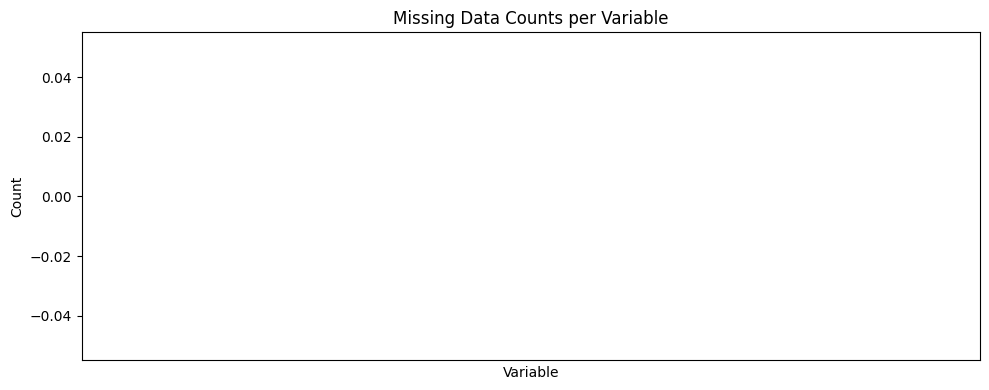

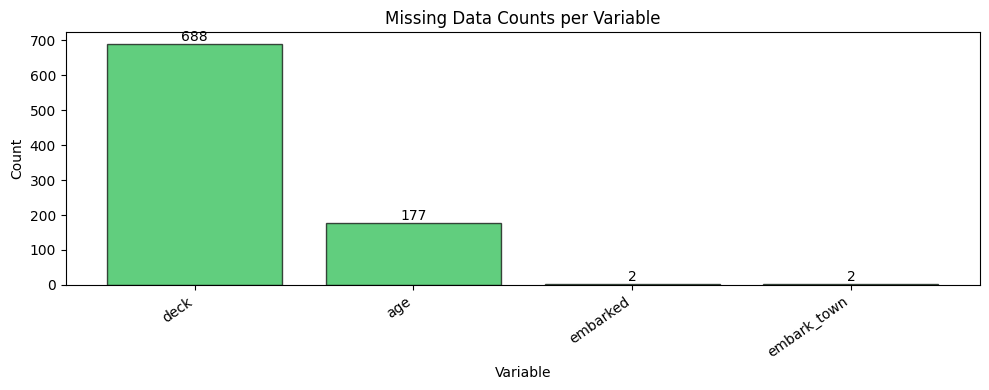

In [33]:
eda_helper_functions.plot_missing_info(train)
eda_helper_functions.plot_missing_info(titanic)


in our training data there r no missing values

### 5. High level analysis of Outliers

we will use IsolationForest , only does on numeric colms

In [ ]:
train.dtypes

airline                    object
date_of_journey    datetime64[ns]
source                     object
destination                object
dep_time                   object
arrival_time               object
duration                    int64
total_stops                 int64
additional_info            object
price                       int64
dtype: object

In [ ]:
[col for col in train.columns if pd.api.types.is_numeric_dtype(train[col])]

['duration', 'total_stops', 'price']

In [ ]:
forest = IsolationForest(n_estimators=100, random_state=12)

In [ ]:
(   
  train
  .assign(
    outlier = forest.fit_predict(
      train
      .drop(columns='price')
      .select_dtypes(include="number")
    )                                       
  )
)

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price,outlier
0,Air India,2019-04-09,Delhi,Cochin,05:55:00,19:15:00,2240,2,No info,7711,-1
1,Air India,2019-06-03,Delhi,Cochin,07:10:00,07:40:00,1470,2,No info,12698,-1
2,Air India,2019-05-15,Kolkata,Banglore,16:45:00,21:05:00,1700,1,No info,7452,-1
3,Vistara,2019-06-15,Chennai,Kolkata,07:05:00,09:20:00,135,0,No info,3687,-1
4,Jet Airways,2019-04-09,Delhi,Cochin,23:05:00,19:00:00,1195,2,No info,9483,-1
...,...,...,...,...,...,...,...,...,...,...,...
635,Multiple Carriers,2019-03-06,Delhi,Cochin,11:30:00,19:15:00,465,1,No info,15077,1
636,Indigo,2019-04-21,Delhi,Cochin,02:00:00,07:45:00,345,1,No info,6258,1
637,Indigo,2019-06-09,Kolkata,Banglore,22:15:00,00:50:00,155,0,No info,5224,1
638,Indigo,2019-05-18,Delhi,Cochin,14:20:00,22:30:00,490,1,No info,7640,1


In [ ]:
(   
  train
  .assign(
    outlier = forest.fit_predict(
      train
      .drop(columns='price')
      .select_dtypes(include="number")
    )                                       
  )
  .outlier.value_counts()
)

outlier
 1    389
-1    251
Name: count, dtype: int64

In [ ]:
(   
  train
  .assign(
    outlier = forest.fit_predict(
      train
      .drop(columns='price')
      .select_dtypes(include="number")
    )                                       
  )
  .query("outlier==-1")
)  # we have 3 numeric colms : duration ,  total_stosp and price 

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price,outlier
0,Air India,2019-04-09,Delhi,Cochin,05:55:00,19:15:00,2240,2,No info,7711,-1
1,Air India,2019-06-03,Delhi,Cochin,07:10:00,07:40:00,1470,2,No info,12698,-1
2,Air India,2019-05-15,Kolkata,Banglore,16:45:00,21:05:00,1700,1,No info,7452,-1
3,Vistara,2019-06-15,Chennai,Kolkata,07:05:00,09:20:00,135,0,No info,3687,-1
4,Jet Airways,2019-04-09,Delhi,Cochin,23:05:00,19:00:00,1195,2,No info,9483,-1
...,...,...,...,...,...,...,...,...,...,...,...
618,Jet Airways,2019-06-03,Delhi,Cochin,17:30:00,19:00:00,1530,1,No info,14714,-1
619,Multiple Carriers,2019-03-03,Delhi,Cochin,07:10:00,21:20:00,850,2,In-flight meal not included,8938,-1
621,Air India,2019-05-21,Kolkata,Banglore,14:30:00,23:15:00,525,2,No info,15107,-1
631,Air India,2019-05-18,Delhi,Cochin,06:05:00,09:25:00,1640,1,No info,7480,-1


In [ ]:
#for detailed analysis, come back to this
(   
  train
  .assign(
    outlier = forest.fit_predict(
      train
      .drop(columns='price')
      .select_dtypes(include="number")
    )                                       
  )
  .query("outlier==-1")
  .duration
  .describe()
)  # we have 3 numeric colms : duration ,  total_stops and price 

count     251.000000
mean      824.661355
std       656.135036
min        80.000000
25%       150.000000
50%       865.000000
75%      1422.500000
max      2245.000000
Name: duration, dtype: float64

there are 250 rows which r outliers, need to insepect more later 

### 6. Pair Plots

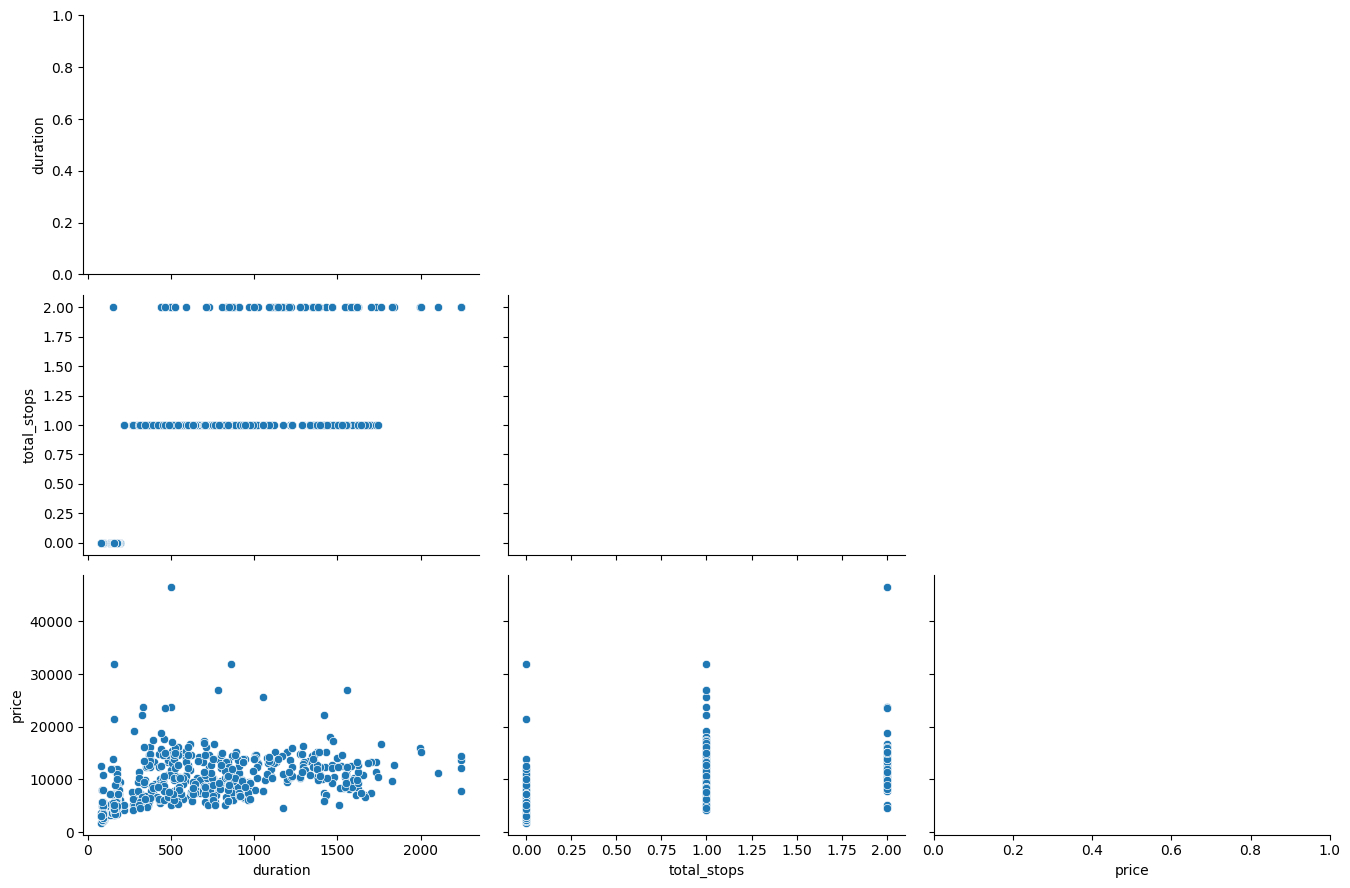

In [ ]:
eda_helper_functions.pair_plots(train)

### 7. Correlation Analysis

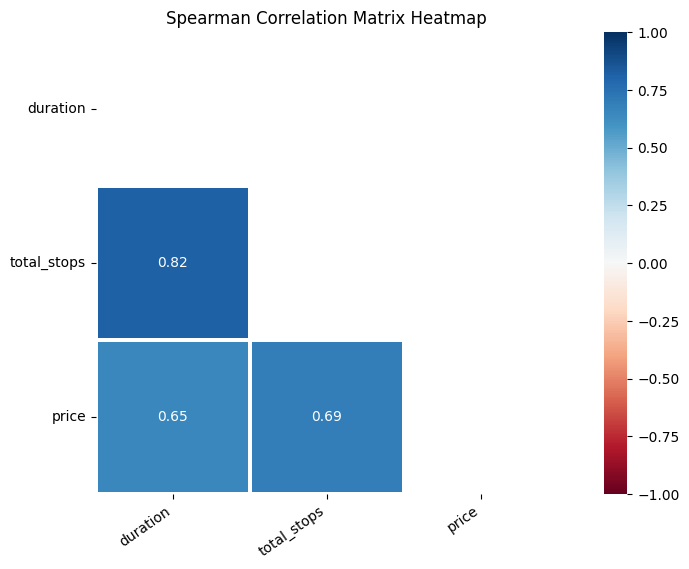

In [ ]:
eda_helper_functions.correlation_heatmap(train) # only for numerical features

In [ ]:
# eda_helper_functions.cramersV_heatmap(train)

In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats  # Required for chi2_contingency

def cramers_v(data, var1, var2):
    ct = pd.crosstab(data[var1], data[var2])
    r, c = ct.shape
    n = ct.values.sum()
    chi2 = stats.chi2_contingency(ct)[0]
    phi2 = chi2 / n

    # Bias correction
    phi2_corr = max(0, phi2 - ((r - 1) * (c - 1)) / (n - 1))
    r_corr = r - ((r - 1) ** 2) / (n - 1)
    c_corr = c - ((c - 1) ** 2) / (n - 1)

    denom = min(c_corr - 1, r_corr - 1)
    if denom <= 0:
        return np.nan

    v = np.sqrt(phi2_corr / denom)
    return min(v, 1.0)  # Clamp to 1.0 max

def plot_cramers_v_heatmap(df):
    cat_cols = df.select_dtypes(include='object').columns.tolist()

    if len(cat_cols) < 2:
        print("❌ Not enough categorical features for Cramér's V heatmap.")
        return

    matrix = pd.DataFrame(index=cat_cols, columns=cat_cols, dtype=float)

    for i, col1 in enumerate(cat_cols):
        for j, col2 in enumerate(cat_cols):
            if i >= j:  # Lower triangle and diagonal
                matrix.loc[col1, col2] = cramers_v(df, col1, col2)
            else:
                matrix.loc[col1, col2] = np.nan

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        matrix,
        annot=True,
        cmap='YlGnBu',
        fmt='.2f',
        mask=np.triu(np.ones(matrix.shape, dtype=bool)),
        square=True,
        cbar_kws={"shrink": 0.75}
    )
    plt.title("Cramér’s V Heatmap (Categorical Features)")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


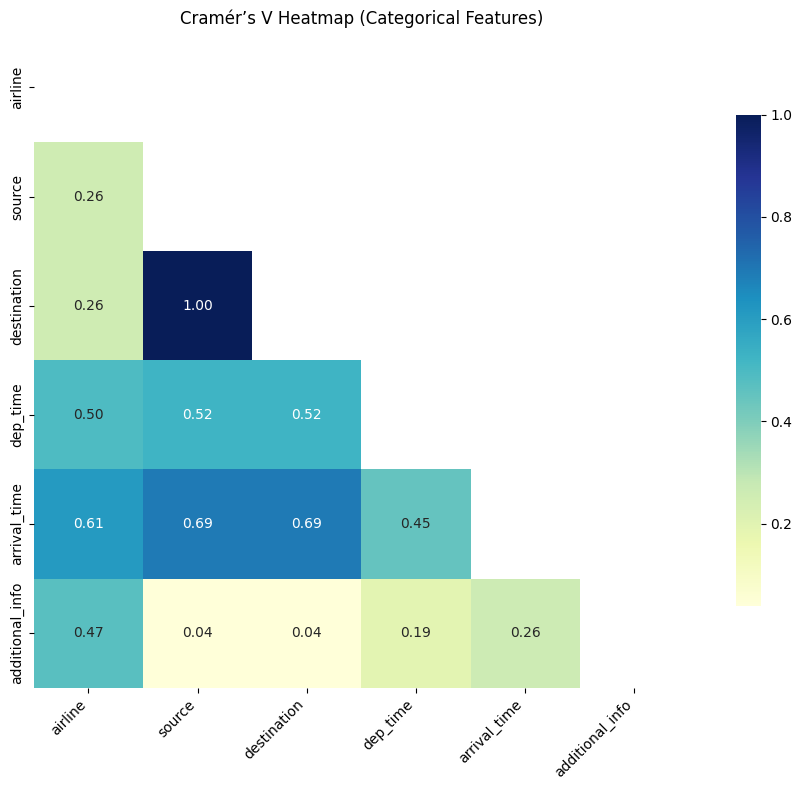

In [39]:
plot_cramers_v_heatmap(train)
